## SNR notebook

- [Initial Settings](#Initial-settings)
- [Signal to noise](#Signal-to-Noise)
- [Error ellipses for b and f](#b-and-f-error-ellipses)
- [Fractional error of b and f as a function of r](#b-and-f-Reid-plot)

In [97]:
import time, datetime
import numpy as np
from numpy import zeros, sqrt, pi, vectorize
from numpy.linalg import pinv, inv
from multiprocessing import Process, Queue
#import matplotlib
#matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from error_analysis_class import *
from noshellavg import *

## Initial settings 

In [98]:
#  (parameter description in class code)
# Fourier K 0.001~10
KMIN = 0.001
KMAX = 2 # 361.32 #502.32
RMIN = 20
RMAX = 180
kmin = KMIN
kmax = KMAX
# the number of k sample point should be 2^n+1 (b/c romb integration)
rN = 200
kN = 1
kN_x = 2**13 + 1
kN_y = 50
#subN = 2**5 + 1
# RSD class

In [99]:
RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, kN_y, logscale = True)

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 50, rN = 200, N_x = 8193
dlnr = 0.0110413295344, dlnk=0.155120458358


Call noshell class

In [100]:
file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
RSDPower.MatterPower(file = file)
#RSDPower.Shell_avg_band()

Construct RSD matter power spectrum (from Camb)

In [101]:
# power spectrum multipoles l = 0,2,4
RSDPower.multipole_P_band_all()

Build three P multipoles l=0,2,4. 

In [102]:
# derivative dXi/dp
RSDPower.derivative_Xi_band_all()

# derivative dXidb, s, f
RSDPower.derivative_bfs_all()
RSDPower.derivative_P_bfs_all()

# P covariance matrix ( nine submatrices C_ll' )
RSDPower.RSDband_covariance_PP_all()

# Xi covariance matrix ( nine submatrices C_ll' )
RSDPower.covariance_Xi_all()
RSDPower.covariance_PXi_All()

multiprocessing 100 %

In [103]:
rcut_max = get_closest_index_in_data( RMAX, RSDPower.rmax )
rcut_min = get_closest_index_in_data( RMIN, RSDPower.rmin )
kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )

In [104]:

matricesXi = [RSDPower.covariance00[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance22[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              np.transpose(RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance44[rcut_max:rcut_min+1,rcut_max:rcut_min+1]]

matricesPP_all = [RSDPower.covariance_PP00,RSDPower.covariance_PP02,\
                RSDPower.covariance_PP04,RSDPower.covariance_PP02,\
                RSDPower.covariance_PP22,RSDPower.covariance_PP24,\
                RSDPower.covariance_PP04,RSDPower.covariance_PP24,\
                RSDPower.covariance_PP44]

matricesPP = [RSDPower.covariance_PP00[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
            RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
            RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
            RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
            RSDPower.covariance_PP22[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
            RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
            RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
            RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
            RSDPower.covariance_PP44[kcut_min:kcut_max+1,kcut_min:kcut_max+1]]

matricesPXi = [RSDPower.covariance_PXi00[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
             RSDPower.covariance_PXi02[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
             RSDPower.covariance_PXi04[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
             RSDPower.covariance_PXi20[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
             RSDPower.covariance_PXi22[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
             RSDPower.covariance_PXi24[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
             RSDPower.covariance_PXi40[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
             RSDPower.covariance_PXi42[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
             RSDPower.covariance_PXi44[kcut_min:kcut_max+1,rcut_max:rcut_min+1]]


Make matrices lists to construt covriance matrices



In [105]:
l1 = RSDPower.kcenter_y.size
l2 = rcut_min+1 - rcut_max
l3 = kcut_max+1 - kcut_min

In [106]:
# combining covariances
C_matrix3PP_all = CombineCovariance3(l1, matricesPP_all)
C_matrix3PP = CombineCovariance3(l3, matricesPP)
C_matrix3Xi = CombineCovariance3(l2, matricesXi)
                                 
#C_matrix3PXi = np.zeros((C_matrix3PXi.shape))
C_matrix3PXi, C_matrix3XiP = CombineCrossCovariance3(l3, l2, matricesPXi, transpose = True)
C_matrix3_tot = np.concatenate((np.concatenate((C_matrix3PP, C_matrix3PXi), axis=1),\
                                np.concatenate((C_matrix3PXi.T, C_matrix3Xi), axis=1)), axis = 0)

Covariance matrices for each estimator. Suffix `_all`  covoers all k scales.  
`C_matrix3_tot`  is a combined covariance matrix. if cross-covariance is zero matrix, The combined one is optimistic.

In [107]:
# inverting matrices
from test_SNR import blockwiseInversion
FisherP_all = inv(C_matrix3PP_all)
FisherP = inv(C_matrix3PP)
FisherXi = blockwiseInversion( C_matrix3Xi, rcut_min+1-rcut_max )
Fisher3_tot = blockwiseInversion( C_matrix3_tot, 3 * (kcut_max+1-kcut_min) )

Use **Blockwise Inversion** method to invert C_xi and combined C.  
엥 솔직히 한번에 뒤집어도 되는 거라서 blockwise inversion 안 써도 될 거 같지만....

Make derivatives. All derivative matrices consist of 3x3 sub matrices.  
Since derivatives between different multipoles becomes zero, off-diagonal sub-matrices are zero.  
Diagonal sub-matrices of P multipoles are one.  

```
derivative_P : dP0/P0, dP2/P2, dP4/P4....  
derivative_correl_avg : dXi0/P0, dXi2/P2, dXi4/P4 ....  
Deriva tives : derivatives of combined estimator. (derivative_P, derivative_correl_avg)
```

In [108]:
# derivatives
derivative_P0 = np.identity(RSDPower.kcenter_y.size)[:,kcut_min:kcut_max+1]
Pzeros = np.zeros((derivative_P0.shape))

derivative_P = np.concatenate((np.concatenate((derivative_P0, Pzeros, Pzeros),axis=1 ),\
                               np.concatenate((Pzeros, derivative_P0, Pzeros),axis=1 ),\
                               np.concatenate((Pzeros, Pzeros, derivative_P0),axis=1 )), axis=0)
Xizeros = np.zeros((RSDPower.dxip0[:,rcut_max:rcut_min+1].shape))
derivative_correl_avg = np.concatenate(( np.concatenate((RSDPower.dxip0[:,rcut_max:rcut_min+1],Xizeros,Xizeros), axis=1),\
                                        np.concatenate((Xizeros,RSDPower.dxip2[:,rcut_max:rcut_min+1],Xizeros), axis=1),\
                                        np.concatenate((Xizeros,Xizeros,RSDPower.dxip4[:,rcut_max:rcut_min+1]), axis=1)),axis=0 )
Derivatives = np.concatenate((derivative_P,derivative_correl_avg), axis=1)

Inner product of Fisher matrices and derivative matrices gives Fisher information matrices in k space from different estimators.  
These Fisher matrices include all input k and r information.  

#### Band-power Fisher matrixes from different estimators

In [109]:
FisherBand_P = FisherP.copy()
FisherBand_P_all = FisherP_all.copy()
FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)

----

## Signal to Noise

SNR = $\sum_{i,j} P_i ~F_{P} ~P_j$  

Reordering vectors and Multipoles

In [110]:
from test_SNR import reorderingVector, reordering

m_P0 = RSDPower.multipole_bandpower0[kcut_min:kcut_max+1]
m_P2 = RSDPower.multipole_bandpower2[kcut_min:kcut_max+1]
m_P4 = RSDPower.multipole_bandpower4[kcut_min:kcut_max+1]
m_P = reorderingVector( [m_P0, m_P2, m_P4] )

In [111]:
re_FisherBand_P_all, _ = reordering( RSDPower, FisherBand_P_all)
re_FisherBand_P, _ = reordering( RSDPower, FisherBand_P)
re_FisherBand_Xi, m_P_all = reordering( RSDPower, FisherBand_Xi)
re_FisherBand_tot, _ = reordering( RSDPower, FisherBand_tot)

P

In [112]:
from test_SNR import blockwise

FP = re_FisherBand_P_all.copy()
PP = m_P_all.copy()

SNRlist_P = []
SNRP = np.dot( np.dot(PP, FP), PP.T )
SNRlist_P.append(SNRP)
for j in range(1, PP.size/3):
    PP = PP[:-3]
    for i in range(0,3):
        FP = blockwise( FP )
    SNRP = np.dot( np.dot(PP, FP), PP.T )
    SNRlist_P.append(SNRP)

SNRlist_P = np.array(SNRlist_P[::-1]).ravel()
kklist = RSDPower.kcenter_y #[kcut_min:kcut_max+1]

print SNRlist_P.shape, kklist.shape

(49,) (49,)


Xi

In [113]:
F = re_FisherBand_Xi.copy()
P = m_P_all.copy()

SNRlist = []
SNR = np.dot( np.dot(P, F), P.T )
SNRlist.append(SNR)
for j in range(1, P.size/3):
    P = P[:-3]
    for i in range(0,3):
        F = blockwise( F )
    SNR = np.dot( np.dot(P, F), P.T )
    SNRlist.append(SNR)

SNRlist = np.array(SNRlist[::-1]).ravel()
kklist2 = RSDPower.kcenter_y

tot

In [114]:
Ft = re_FisherBand_tot.copy()
Pt = m_P_all.copy()

SNRlist_t = []
SNRt = np.dot( np.dot(Pt, Ft), Pt.T )
SNRlist_t.append(SNRt)
for j in range(1, Pt.size/3):
    Pt = Pt[:-3]
    for i in range(0,3):
        Ft = blockwise( Ft )
    SNRt = np.dot( np.dot(Pt, Ft), Pt.T )
    SNRlist_t.append(SNRt)

SNRlist_t = np.array(SNRlist_t[::-1]).ravel()
#kklist2 = RSDPower.kcenter_y

In [115]:
#from test_SNR import convergence_P, convergence_Xi
#kklist, SNRPP = convergence_P(RSDPower, KMIN, KMAX)
#kklist2, SNRXI = convergence_Xi(RSDPower, RMIN, RMAX , None, None)

Plotting

fig save to figure/SNR.png


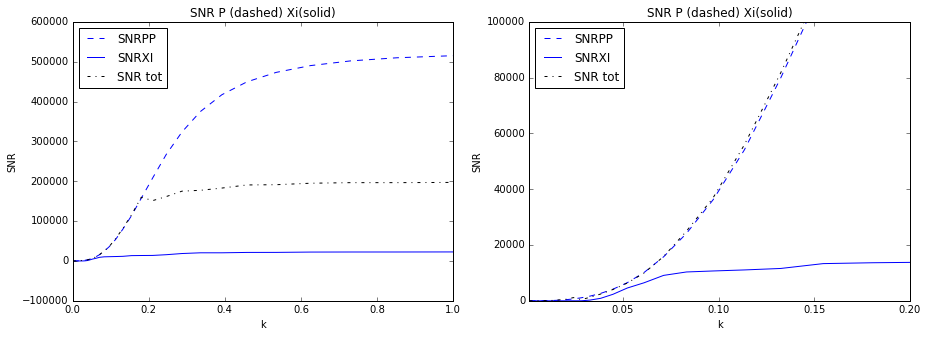

In [116]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (15, 5))
ax.plot(kklist, SNRlist_P, linestyle = '--', label = 'SNRPP')
ax.plot(kklist2, SNRlist, linestyle = '-', color = ax.lines[-1].get_color(), label='SNRXI')
ax.plot(kklist2, SNRlist_t, linestyle = '-.', color = 'black', label='SNR tot')
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel('k')
#ax.set_ylim(1e-12, 1e+10)
ax.set_xlim(1e-3, 1)
ax.set_ylabel('SNR')
ax.set_title('SNR P (dashed) Xi(solid)')
ax.legend(loc='best')

ax2.plot(kklist, SNRlist_P, linestyle = '--', label = 'SNRPP')
ax2.plot(kklist2, SNRlist, linestyle = '-', color = ax2.lines[-1].get_color(), label='SNRXI')
ax2.plot(kklist2, SNRlist_t, linestyle = '-.', color = 'black', label='SNR tot')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlabel('k')
ax2.set_ylim(-1, 1e+5)
ax2.set_xlim(1e-3, 0.2)
ax2.set_ylabel('SNR')
ax2.set_title('SNR P (dashed) Xi(solid)')
ax2.legend(loc='best')

figname='figure/SNR.png'
fig.savefig(figname)
print 'fig save to', figname

## Delta Cumulative Sinal to Noise

$\Delta~\sum (S/N)^2$

In [117]:
def DeltaCumulativeSNR(RSDPower, re_FisherBand_P, m_P_all, kmin, kmax):
    
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )

    FP = re_FisherBand_P.copy()[3*kcut_min:3*kcut_max+3, 3*kcut_min:3*kcut_max+3]
    PP = m_P_all.copy()[3*kcut_min:3*kcut_max+3]
    
    SNRlist_P = []
    SNRP = np.dot( np.dot(PP, FP), PP.T )
    SNRlist_P.append(SNRP)
    for j in range(1, PP.size/3):
        PP = PP[:-3]
        for i in range(0,3):
            FP = blockwise( FP )
        SNRP = np.dot( np.dot(PP, FP), PP.T )
        SNRlist_P.append(SNRP)

    SNRlist_P = np.array(SNRlist_P[::-1]).ravel()
    kklist = RSDPower.kcenter_y[kcut_min:kcut_max+1]
    return kklist, SNRlist_P

Plotting

fig save to  figure/DeltaSNR.png


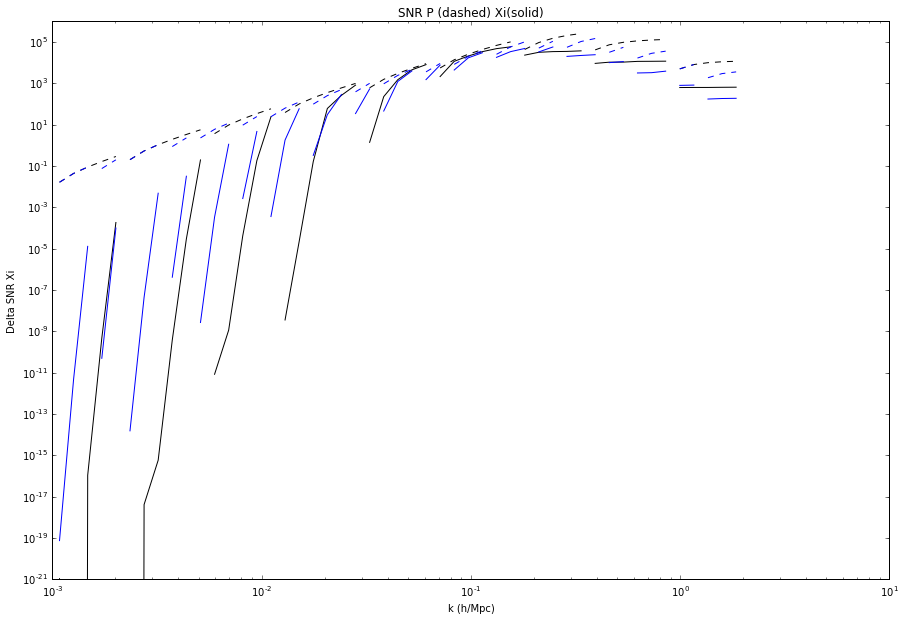

In [122]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

kkk = np.logspace(np.log10(KMIN), np.log10(KMAX), 10)
for i in range(kkk.size -1):   
    ks, SNRs = DeltaCumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kkk[i], kkk[i+1])
    _, SNRXis = DeltaCumulativeSNR(RSDPower, re_FisherBand_Xi, m_P_all, kkk[i], kkk[i+1])
    ax.plot(ks, SNRs, linestyle='--', color = 'black' )
    ax.plot(ks, SNRXis, linestyle='-', color = 'black' ) #ax.lines[-1].get_color())

kkk2 = np.logspace(np.log10(KMIN), np.log10(KMAX), 20)
for i in range(kkk2.size -1):   
    ks, SNRs = DeltaCumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kkk2[i], kkk2[i+1])
    _, SNRXis = DeltaCumulativeSNR(RSDPower, re_FisherBand_Xi, m_P_all, kkk2[i], kkk2[i+1])
    ax.plot(ks, SNRs, linestyle='--', color = 'blue' )
    ax.plot(ks, SNRXis, linestyle='-', color = 'blue' ) #ax.lines[-1].get_color())
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('k (h/Mpc)')
ax.set_ylabel('Delta SNR Xi')
ax.set_title('SNR P (dashed) Xi(solid)')
#ax.legend(loc='best')
figname = 'figure/DeltaSNR.png'
fig.savefig(figname)
print 'fig save to ',figname

----

## b and f error ellipses 

I am going to test three different ranges of r and k.  
1. `r = 0.1 - 180 Mpc/h, k = 0.001 - 2 Mpc/h`  
2. `r = 24 - 152 Mpc/h, k = 0.01 - 0.2 Mpc/h`
3. `r = 29 - 200 Mpc/h, k = 0.02 - 0.3 Mpc/h`

To get contour ellipses for paramters, need to project Fisher matrices to the paramter space.  
Construct derivative matrices of dP/da (a can be any parameter such as b, f, sigma, shot noise...)

In [123]:
matrices2P_cut = [RSDPower.dPb0[kcut_min:kcut_max+1], RSDPower.dPb2[kcut_min:kcut_max+1],\
                  RSDPower.dPb4[kcut_min:kcut_max+1], RSDPower.dPf0[kcut_min:kcut_max+1],\
                  RSDPower.dPf2[kcut_min:kcut_max+1], RSDPower.dPf4[kcut_min:kcut_max+1],\
                  RSDPower.dPs0[kcut_min:kcut_max+1], RSDPower.dPs2[kcut_min:kcut_max+1],\
                  RSDPower.dPs4[kcut_min:kcut_max+1]]

matrices2P = [RSDPower.dPb0, RSDPower.dPb2, RSDPower.dPb4,\
              RSDPower.dPf0, RSDPower.dPf2, RSDPower.dPf4,\
              RSDPower.dPs0, RSDPower.dPs2, RSDPower.dPs4]

XP, XP2 = CombineDevXi(l1, matrices2P)
XP_cut, XP2_cut = CombineDevXi(l3, matrices2P_cut)

Suffix `_cut` stands for one in limited k range.  

Projected Fisher matrices to the paramter spaces by multiplying derivatives and invert it again to get covariance matrices.  
Diagonal components of covariance matrix stand for squared error at `KMAX` or `RMIN`.

In [124]:
FisherPP = np.dot( np.dot( XP_cut, inv(C_matrix3PP)), XP_cut.T)
FisherXi = np.dot( np.dot( XP, FisherBand_Xi), XP.T)
Fishertot = np.dot( np.dot( XP, FisherBand_tot), XP.T)

Cov_PP = inv(FisherPP)[0:2,0:2]
Cov_Xi = inv(FisherXi)[0:2,0:2]
Cov_tot = inv(Fishertot)[0:2,0:2]

In [125]:
elllist = confidence_ellipse(RSDPower.b, RSDPower.f, Cov_PP, Cov_Xi, Cov_tot )

Plot confident ellipses

fig save to : figure/ellipse_RSD.png


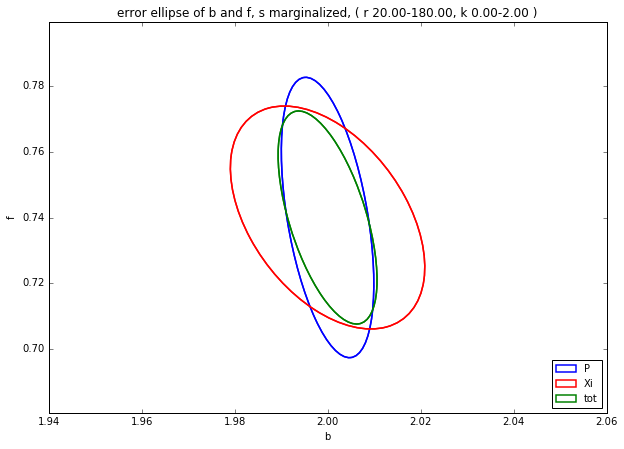

In [126]:
fig, ax = plt.subplots(figsize=(10,7))
for e in elllist:
    ax.add_artist(e)
    ax.add_artist(e)
    #e.set_alpha(0.2)
    e.set_clip_box(ax.bbox)

xmin = RSDPower.b*0.97
xmax = RSDPower.b*1.03
ymin = RSDPower.f*0.92
ymax = RSDPower.f*1.08
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('b')
ax.set_ylabel('f')
labellist = ['P', 'Xi', 'tot', 'P_n', 'Xi_n', 'tot_n']
ax.legend(elllist, labellist, loc=4, prop={'size':10})
#ax.set_title( 'error ellipse of b and f, s marginalized, RSD scale ( r24-152, k0.01-0.2 )' )
#ax.set_title( 'error ellipse of b and f, s marginalized, BAO scale ( r29-200, k0.02-0.3 )' )
ax.set_title( 'error ellipse of b and f, s marginalized, ( r {:>0.2f}-{:>0.2f}, k {:>0.2f}-{:>0.2f} )'\
             .format(RMIN, RMAX, KMIN, KMAX) )
figname = 'figure/ellipse_RSD.png'
fig.savefig(figname)
print 'fig save to :', figname
#plt.close(fig)

Add shot noise as a paramter and marginalize it.

In [127]:
dPN0 = np.ones(RSDPower.kcenter_y.size)
dPN1 = np.zeros(RSDPower.kcenter_y.size)
dPN2 = dPN1.copy()
XP_N = np.vstack((XP,np.array([dPN0, dPN1, dPN2]).ravel()))
XP_N_cut = np.vstack((XP_cut, np.array([dPN0[kcut_min:kcut_max+1],\
                                        dPN1[kcut_min:kcut_max+1],\
                                        dPN2[kcut_min:kcut_max+1]]).ravel()))

FisherPP_N = np.dot( np.dot( XP_N_cut, inv(C_matrix3PP)), XP_N_cut.T)
FisherXi_N = np.dot( np.dot( XP_N, FisherBand_Xi), XP_N.T)
Fishertot_N = np.dot( np.dot( XP_N, FisherBand_tot), XP_N.T)

Cov_PP_N = inv(FisherPP_N)[0:2,0:2]
Cov_Xi_N = inv(FisherXi_N)[0:2,0:2]
Cov_tot_N = inv(Fishertot_N)[0:2,0:2]

In [128]:
elllist = confidence_ellipse(RSDPower.b, RSDPower.f, Cov_PP, Cov_Xi, Cov_tot, Cov_PP_N, Cov_Xi_N, Cov_tot_N)

fig save to : figure/ellipse_RSD.png


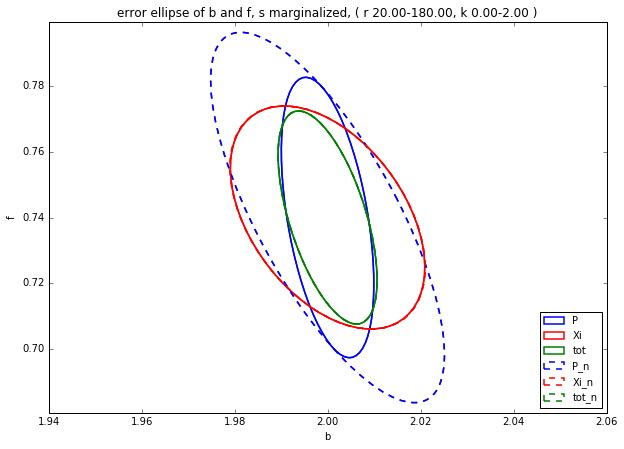

In [129]:
fig, ax = plt.subplots(figsize=(10,7))
for e in elllist:
    ax.add_artist(e)
    ax.add_artist(e)
    #e.set_alpha(0.2)
    e.set_clip_box(ax.bbox)

xmin = RSDPower.b*0.97
xmax = RSDPower.b*1.03
ymin = RSDPower.f*0.92
ymax = RSDPower.f*1.08
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('b')
ax.set_ylabel('f')
labellist = ['P', 'Xi', 'tot', 'P_n', 'Xi_n', 'tot_n']
ax.legend(elllist, labellist, loc=4, prop={'size':10})
#ax.set_title( 'error ellipse of b and f, s marginalized, RSD scale ( r24-152, k0.01-0.2 )' )
#ax.set_title( 'error ellipse of b and f, s marginalized, BAO scale ( r29-200, k0.02-0.3 )' )
ax.set_title( 'error ellipse of b and f, s marginalized, ( r {:>0.2f}-{:>0.2f}, k {:>0.2f}-{:>0.2f} )'\
             .format(RMIN, RMAX, KMIN, KMAX) )
figname = 'figure/ellipse_RSD.png'
fig.savefig(figname)
print 'fig save to :', figname

----

## b and f Reid plot

I could reuse Fisher matrices and derivatives obtained above, but if I reorder matrices, it would be more convenient to cut out matrices by scales.

Reorder Xi covariance matrix.

In [130]:
from test_SNR import reordering, reorderingVector, blockwise
re_C_matrix3Xi, _ = reordering( RSDPower, C_matrix3Xi )

Reorder derivatives

In [131]:
# for xi
Xizeros = np.zeros((RSDPower.dxip0[:, rcut_max:rcut_min+1].shape))
dxip0 = reorderingVector([RSDPower.dxip0[:, rcut_max:rcut_min+1], Xizeros, Xizeros])
dxip2 = reorderingVector([Xizeros, RSDPower.dxip2[:, rcut_max:rcut_min+1], Xizeros])
dxip4 = reorderingVector([Xizeros, Xizeros, RSDPower.dxip4[:, rcut_max:rcut_min+1]])
dxip = np.vstack(( dxip0, dxip2, dxip4 ))

dPb = np.hstack(([RSDPower.dPb0, RSDPower.dPb2, RSDPower.dPb4]))
dPf = np.hstack(([RSDPower.dPf0, RSDPower.dPf2, RSDPower.dPf4]))
dPs = np.hstack(([RSDPower.dPs0, RSDPower.dPs2, RSDPower.dPs4]))
dPn = np.hstack(([np.ones(RSDPower.dPs0.size),np.zeros(RSDPower.dPs0.size),np.zeros(RSDPower.dPs0.size) ]))

dPbf = np.vstack(( dPb, dPf ))
dPbfs = np.vstack(( dPb, dPf, dPs ))
dPbfsn = np.vstack(( dPb, dPf, dPs, dPn ))

# for P (limited k range. but not sure these are needed for reid plots...)
dPb_cut = reorderingVector([RSDPower.dPb0[kcut_min:kcut_max+1], \
                            RSDPower.dPb2[kcut_min:kcut_max+1], \
                            RSDPower.dPb4[kcut_min:kcut_max+1]])
dPf_cut = reorderingVector([RSDPower.dPf0[kcut_min:kcut_max+1], \
                            RSDPower.dPf2[kcut_min:kcut_max+1], \
                            RSDPower.dPf4[kcut_min:kcut_max+1]])
dPbf_cut = np.vstack(( dPb_cut, dPf_cut )) #, dPs ))

Calculate fractional error of f and b.

1) bandpower from $\xi$

In [132]:
# err list
errb, errbn = [], [] 
errf, errfn = [], [] # when n marginalized
rlist = [] 

# First term (all scale of r)
F = np.dot( np.dot(dxip, inv(re_C_matrix3Xi)), dxip.T ) 

# shot noise determined
Fparams = np.dot( np.dot(dPbfs, F), dPbfs.T )
Cparams = inv(Fparams)
sigma_b, sigma_f = Cparams[0,0], Cparams[1,1]
errb.append(np.sqrt(sigma_b)/RSDPower.b)
errf.append(np.sqrt(sigma_f)/RSDPower.f)
reverser = RSDPower.rcenter[rcut_max:rcut_min+1][::-1]
rlist.append(reverser[0])

# shot noise marginalized
Fparamsn = np.dot( np.dot(dPbfsn, F), dPbfsn.T )
Cparamsn = inv(Fparamsn)
sigma_bn, sigma_fn = Cparamsn[0,0], Cparamsn[1,1]
errbn.append(np.sqrt(sigma_bn)/RSDPower.b)
errfn.append(np.sqrt(sigma_fn)/RSDPower.f)

C = re_C_matrix3Xi.copy()
DXIP = dxip.copy()
# now from 2nd term
for j in range(1, rcut_min + 1 - rcut_max):

    DXIP = DXIP[:, :-3 ]
    C = C[:-3, :-3 ]
    F = np.dot( np.dot(DXIP, inv(C)), DXIP.T )
    Fparams = np.dot( np.dot(dPbfs, F), dPbfs.T )
    Cparams = inv(Fparams)
    sigma_b, sigma_f = Cparams[0,0], Cparams[1,1]
    errb.append(np.sqrt(sigma_b)/RSDPower.b)
    errf.append(np.sqrt(sigma_f)/RSDPower.f)

    Fparamsn = np.dot( np.dot(dPbfsn, F), dPbfsn.T )
    Cparamsn = inv(Fparamsn)
    sigma_bn, sigma_fn = Cparamsn[0,0], Cparamsn[1,1]
    errbn.append(np.sqrt(sigma_bn)/RSDPower.b)
    errfn.append(np.sqrt(sigma_fn)/RSDPower.f)

    #rlist.append(1.15 * np.pi/klist[j])
    rlist.append(reverser[j])

Plotting

2) bandpower from P

In [133]:
from test_SNR import reorderingVector
re_F = re_FisherBand_P_all.copy()

re_dPb = reorderingVector([RSDPower.dPb0, RSDPower.dPb2, RSDPower.dPb4])
re_dPf = reorderingVector([RSDPower.dPf0, RSDPower.dPf2, RSDPower.dPf4])
re_dPbf = np.vstack(( re_dPb, re_dPf )) #, dPs ))

D = re_dPbf.copy()

In [134]:
# from P
errPb = []
errPf = []
rlistP = []
klist = RSDPower.kcenter_y[::-1]
FPparams = np.dot( np.dot(D, re_F), D.T )
                  
CPparams = inv(FPparams)
sigma_Pb, sigma_Pf = CPparams[0,0], CPparams[1,1]
errPb.append(np.sqrt(sigma_Pb)/RSDPower.b)
errPf.append(np.sqrt(sigma_Pf)/RSDPower.f)
rlistP.append( 1.15 * np.pi/klist[0])


for j in range(1, klist.size ):
    # from P in r
    D = D[:,:-3]
    re_F = re_F[:-3, :-3]
    FPparams = np.dot( np.dot(D, re_F), D.T )
    CPparams = inv(FPparams)
    sigma_Pb, sigma_Pf = CPparams[0,0], CPparams[1,1]
    errPb.append(np.sqrt(sigma_Pb)/RSDPower.b)
    errPf.append(np.sqrt(sigma_Pf)/RSDPower.f)
    rlistP.append( 1.15 * np.pi/klist[j])

Plotting

fig save to  figure/reid.png


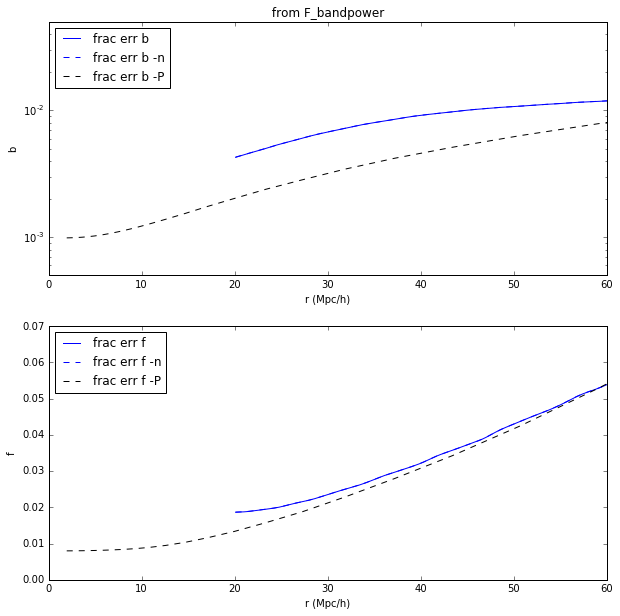

In [135]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(10, 10))
ax.plot(rlist, errb, label = 'frac err b')
ax2.plot(rlist, errf, label = 'frac err f')
ax.plot(rlist, errbn, color = ax.lines[-1].get_color(), linestyle = '--', label = 'frac err b -n')
ax2.plot(rlist, errfn, color = ax.lines[-1].get_color(), linestyle = '--', label = 'frac err f -n')
ax.plot(rlistP, errPb, 'k--', label = 'frac err b -P')
ax2.plot(rlistP, errPf, 'k--', label = 'frac err f -P')
ax.set_xlim(0, 60)
ax.set_ylim(0.0005, 0.05)
ax.set_ylabel('b')
ax.set_xlabel('r (Mpc/h)')
ax.set_yscale('log')
ax2.set_xlim(0,60)
ax2.set_ylim(0.00, 0.07)
ax2.set_ylabel('f')
ax2.set_xlabel('r (Mpc/h)')

ax.legend(loc = 'best')
ax2.legend(loc='best')
ax.set_title(' from F_bandpower ')
figname = 'figure/reid.png'
fig.savefig(figname)
print 'fig save to ', figname

----